In [1]:
import pandas as pd
import mne
import sys
import platform
import os
import scipy.io
import base.files_in_out as files_in_out
import numpy as np

if platform.system()=='Darwin':
    os.chdir('/Volumes/BBC/BBC/WP1/data/EEG/tsk/')
    sys.path.append('/Users/leupinv/BBC/WP1/data/Code/python/BBC')
    #if this doesn't work pound line right above this, restart the kernel, rerun the cell. 
    #Then uncomment the same line and rerun

else:
    #os.chdir('Z:/BBC/WP1/data/EEG/tsk')
    sys.path.append('C:/Users/Vivi/switchdrive/BBC/WP1/data/Code/python/BBC')
    os.chdir('Z:/BBC/WP1/data/EEG/tsk')
from base.files_in_out import getListOfFiles,GetFiles
import base.base_constants as b_cs
import raw_export.raw_export_helper as hp




/opt/anaconda3/envs/mne_13/lib/python3.9/site-packages/mne/datasets/eegbci/eegbci.py:8: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


In [2]:
for g_num in b_cs.G_N[1:]:
    raw = hp.load_raw_data(g_num)
    onsets, durations, descriptions, event_table = hp.parse_annotations(raw)
    event_table = event_table.sort_values(by="time").reset_index(drop=True)
    new_raw = hp.set_new_annotations(raw, onsets, durations, descriptions)
    hp.save_outputs(new_raw, event_table, g_num, files_in_out)

Opening raw data file raw/g12/g12_n_tsk_ICA_rec-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Range : 0 ... 831487 =      0.000 ...  3247.996 secs
Ready.
Reading 0 ... 831487  =      0.000 ...  3247.996 secs...
g12_n_tsk_ICA_rec-raw


In [4]:
g_num='g12'
raw = mne.io.read_raw_fif(f"raw/{g_num}/{g_num}_n_tsk_ICA_rec-raw.fif", preload=True)

Opening raw data file raw/g12/g12_n_tsk_ICA_rec-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Range : 0 ... 831487 =      0.000 ...  3247.996 secs
Ready.
Reading 0 ... 831487  =      0.000 ...  3247.996 secs...


In [5]:
raw.plot()

Opening raw-browser...
Using pyopengl with version 3.1.7


In [8]:
annot=raw.annotations

In [3]:
for g_num in b_cs.G_N:
    # Load  MNE Raw object (example)
    raw = mne.io.read_raw_fif(f"raw/{g_num}/{g_num}_n_tsk_ICA_rec-raw.fif", preload=True)
    # Extract the data (channels × time)
    data = raw.get_data()  # Shape: (n_channels, n_times)
    # Extract channel names and sampling rate
    channel_names = raw.ch_names
    sfreq = raw.info["sfreq"]
    #raw.drop_channels(['EXG1','Erg1','Status'])
    annotations=raw.annotations
    # Convert onsets from seconds to sample
    sample_indices = np.round(annotations.onset * sfreq).astype(int)
    # Parse the descriptions and filter/remap events
    filtered_onsets = []
    filtered_durations = []
    filtered_descriptions = []

    # Create event table
    # Parse the descriptions and create the event table
    event_data = {
        "time": [],  # Onset in seconds
        "event": [],  # Simplified event type ("hep" or "vep")
        "awareness": [],  # Awareness state ("aware" or "unaware")
        "duration": [],  # Duration in seconds
        "card_phase": [], # cardiac phase
        "rsp_phase":[],# rsp phase
    }


    for i, desc in enumerate(annotations.description):
        # Split the description into tags
        tags = desc.split("/")
        if "bad" in tags[0].lower():
            continue

        # Check if the event matches the stimulus criteria
        # Must contain "vep", "normal", "correct"
        if (
                "normal" in tags[1].lower() and  # Check for "normal" in the second tag
                "correct" in tags[2].lower()  # Check for "correct" in the third tag
        ):
            # Check for hep events with RRCA or RRCU
            if "hep" in tags[0].lower():
                if tags[-1] in ["RRCA", "RRCU"]:
                    condition_name = "hep"  # Collapse RRCA and RRCU into "hep"
                    awareness = "aware" if tags[-1] == "RRCA" else "unaware"
                    card_phase='dia' if tags[-3]=='R2'else 'sys'
                    rsp_phase='inh'if tags[-2]=='inh' else 'exh'
                else:
                    continue  # Skip if not RRCA or RRCU
                filtered_onsets.append(annotations.onset[i])
                filtered_durations.append(annotations.duration[i])
                filtered_descriptions.append(condition_name)
                event_data["time"].append(annotations.onset[i])
                event_data["event"].append(condition_name)
                event_data["awareness"].append(awareness)
                event_data["duration"].append(annotations.duration[i])
                event_data["card_phase"].append(card_phase)
                event_data["rsp_phase"].append(rsp_phase)

            # Check for vep events with aware or unaware
            elif "vep" in tags[0].lower():
                if "aware" in tags[3].lower() or "unaware" in tags[3].lower():
                    condition_name = "vep"  # Collapse aware and unaware into "vep"
                    awareness = "unaware" if "unaware" in tags[3].lower() else "aware"
                    card_phase='dia' if tags[-2]=='dia'else 'sys'
                    rsp_phase='inh'if tags[-1]=='inh' else 'exh'
                else:
                    continue  # Skip if not aware or unaware
                filtered_onsets.append(annotations.onset[i])
                filtered_durations.append(annotations.duration[i])
                filtered_descriptions.append(condition_name)
                event_data["time"].append(annotations.onset[i])
                event_data["event"].append(condition_name)
                event_data["awareness"].append(awareness)
                event_data["duration"].append(annotations.duration[i])
                event_data["card_phase"].append(card_phase)
                event_data["rsp_phase"].append(rsp_phase)
    # Create a DataFrame from the event data
    event_table = pd.DataFrame(event_data)
    # Sort the event table by time (ensures chronological order)
    event_table = event_table.sort_values(by="time").reset_index(drop=True)

    # Fix HEP cardiac phase to match the corresponding VEP phase (if different)
    corrected_card_phases = event_table["card_phase"].copy()
    # Loop over the event table to find hep-vep pairs
    for i in range(1, len(event_table)):
        if event_table.loc[i, "event"] == "vep" and event_table.loc[i - 1, "event"] == "hep":
            # Check if they are close in time (same trial)
            time_diff = event_table.loc[i, "time"] - event_table.loc[i - 1, "time"]
            print(time_diff)
            if time_diff < 2:  # Adjust threshold as needed
                hep_idx = i - 1
                vep_idx = i
                # Update the HEP card_phase to match the VEP one
                if event_table.loc[hep_idx, "card_phase"] != event_table.loc[vep_idx, "card_phase"]:
                    corrected_card_phases[hep_idx] = event_table.loc[vep_idx, "card_phase"]
    # Apply corrected phases
    event_table["card_phase"] = corrected_card_phases

    # Create a new Annotations object with the simplified conditions
    new_annotations = mne.Annotations(
        onset=filtered_onsets,  # Onsets in seconds
        duration=filtered_durations,  # Durations in seconds
        description=filtered_descriptions  # Simplified descriptions ("hep" or "vep")
    )
    # Set the new annotations in the Raw object, replacing the old ones
    new_raw=raw.copy()
    new_raw.set_annotations(new_annotations)

    new_raw.pick_types(eeg=True)
    #parametres to save output
    eeg_format='fif'
    eeg_exp='tsk'
    datafolder='raw'
    files=files_in_out.GetFiles(filepath=datafolder,eeg_format=eeg_format,g_num=g_num)
    files.select_condition('n')
    files.get_info(end_fix=29)
    files.current_filename=files.current_filename[:9]
    output_file_eeg=files.out_filename(type_sig='deconv',file_end='eeg_data.set')
    output_file_table=files.out_filename(type_sig='deconv',file_end='event_table_sys.csv')
    # Save the Raw object to a .set file for EEGLAB
    #mne.export.export_raw(output_file_eeg,raw=new_raw,overwrite=True)
    # Save the event table to a CSV file
    event_table.to_csv(output_file_table, index=False)




Opening raw data file raw/g01/g01_n_tsk_ICA_rec-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Range : 0 ... 678399 =      0.000 ...  2649.996 secs
Ready.
Reading 0 ... 678399  =      0.000 ...  2649.996 secs...
0.3671869999999995
0.5302730000000011
0.22851599999999905
0.19921899999999937
0.6962890000000002
0.27343700000000126
0.5068359999999998
0.7226569999999981
0.9033200000000008
0.713867999999998
0.7070310000000006
0.03710900000000095
0.5039060000000006
0.6318359999999998
0.6835939999999994
0.3613280000000003
0.9804680000000019
0.6855469999999997
0.03320399999999779
0.7138669999999934
0.4072259999999943
0.13476599999999905
0.20117199999999968
0.014649000000005685
0.3925780000000003
0.5029300000000063
0.8769529999999861
0.7890629999999987
0.3554680000000019
0.2626949999999937
0.07617100000000221
0.9804690000000136
0.6699219999999997
0.7949219999999997
0.9482420000000076
0.7636719999999997
0.7353509999999943
0.124022999999994
0.1

IndexError: list index out of range

In [3]:
# check vep subject
g_num='g10'
epo_vep=mne.read_epochs(f'preproc/{g_num}/{g_num}_epochs/{g_num}_final/{g_num}_n_tsk_cfa_vep_clean_epo.fif')

Reading Z:\BBC\WP1\data\EEG\tsk\preproc\g10\g10_epochs\g10_final\g10_n_tsk_cfa_vep_clean_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 40 columns
786 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


In [3]:
%matplotlib qt
epo_vep[('vep/normal/correct')].average().crop(-0.3,0.6).plot(picks='A15')

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\Vivi\AppData\Local\Temp\ipykernel_22772\568287729.py:2: RuntimeWarning: tmin is not in time interval. tmin is set to <class 'mne.evoked.EvokedArray'>.tmin (-0.199219 s)
  epo_vep[('vep/normal/correct')].average().crop(-0.3,0.6).plot(picks='A15')


Need more than one channel to make topography for eeg. Disabling interactivity.


<Figure size 640x300 with 1 Axes>

Reading Z:\BBC\WP1\data\EEG\tsk\preproc\g10\g10_epochs\g10_final\g10_n_tsk_cfa_hep_clean_epo.fif ...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Found the data of interest:
        t =    -199.22 ...    1000.00 ms
        0 CTF compensation matrices available
0 bad epochs dropped
Adding metadata with 40 columns
1502 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated


C:\Users\Vivi\AppData\Local\Temp\ipykernel_23564\3032453574.py:2: RuntimeWarning: tmin is not in Evoked time interval. tmin is set to evoked.tmin (-0.199219 sec)
  epo_hep[('hep/RRCA')].average().crop(-0.3,0.6).plot(picks='A15')


Need more than one channel to make topography for eeg. Disabling interactivity.


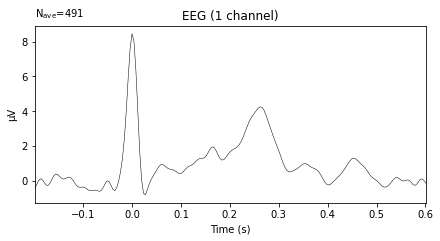

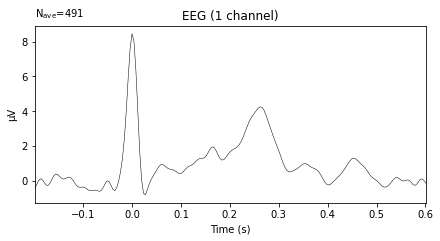

In [5]:
epo_hep=mne.read_epochs(f'preproc/{g_num}/{g_num}_epochs/{g_num}_final/{g_num}_n_tsk_cfa_hep_clean_epo.fif')
epo_hep[('hep/RRCA')].average().crop(-0.3,0.6).plot(picks='A15')

In [4]:
# Load your MNE Raw object (example)
raw = mne.io.read_raw_fif(f"raw/{g_num}/{g_num}_n_tsk_ICA_rec-raw.fif", preload=True)
# Extract the data (channels × time)
data = raw.get_data()  # Shape: (n_channels, n_times)
# Extract channel names and sampling rate
channel_names = raw.ch_names
sfreq = raw.info["sfreq"]

Opening raw data file raw/g10/g10_n_tsk_ICA_rec-raw.fif...
    Read a total of 1 projection items:
        Average EEG reference (1 x 128) active
    Range : 0 ... 649983 =      0.000 ...  2538.996 secs
Ready.
Reading 0 ... 649983  =      0.000 ...  2538.996 secs...


In [10]:
filedir=f'preproc/{g_num}/{g_num}_mrk_DF/{g_num}_n_tsk_metadata.feather'
stim_df=pd.read_feather(filedir)
stim_df

,TF,RT,difficulty,accuracy,awareness,cardiac_phase,RRI,HeartRate,HeartRate_post,HeartRate_rolling_5_before,...,inh_stim_int,mrk_card_awa_RR,mrk_rsp_awa_RR,signal_type,sys_mask,stim_idx,ECG_Phase_Completion_Ventricular,ECG_Phase_Completion_Atrial,RSP_Phase_Completion,RSP_Amplitude
0,11656,924.617188,normal,correct,unaware,sys,1.028320,58.347578,54.808207,56.472632,...,0.000000,RRCU,RRECU,hep,1.0,0.0,-1.000000,0.000000,0.185432,0.003602
1,11909,924.617188,normal,correct,unaware,dia,1.028320,58.347578,54.808207,56.472632,...,0.000000,no_val,no_val,hep,1.0,0.0,-0.231003,0.291475,0.262215,0.003496
2,11970,924.617188,normal,correct,unaware,sys,1.028320,58.347578,54.808207,56.472632,...,5.139648,no_val,no_val,vep,1.0,0.0,-0.045593,0.361751,0.280728,0.003471
3,12925,184.382812,normal,correct,unaware,sys,1.028320,58.347578,54.808207,56.472632,...,5.139648,no_val,no_val,xns,1.0,0.0,-0.341463,0.229299,0.570561,0.003113
4,13830,874.812500,easy,mistake,unaware,sys,1.139648,52.647815,51.673675,56.761203,...,0.000000,RRMU,RREMU,hep,1.0,1.0,-1.000000,0.000000,0.845220,0.002836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3838,2588463,82.820312,normal,mistake,unaware,dia,1.111328,53.989455,52.111959,51.651591,...,8.005859,no_val,no_val,xns,0.0,958.0,-0.254286,0.262840,0.684856,0.002235
3839,2589381,800.593750,normal,correct,aware,sys,1.143555,52.467976,53.519164,51.621236,...,0.000000,RRCA,RRECA,hep,0.0,959.0,-1.000000,0.000000,0.776437,0.002266
3840,2589650,800.593750,normal,correct,aware,dia,1.143555,52.467976,53.519164,51.621236,...,0.000000,no_val,no_val,hep,0.0,959.0,-0.229226,0.273652,0.803272,0.002274
3841,2589785,800.593750,normal,correct,aware,dia,1.143555,52.467976,53.519164,51.621236,...,10.222656,no_val,no_val,vep,0.0,959.0,0.065854,0.410987,0.816740,0.002278


In [4]:
#raw.drop_channels(['EXG1','Erg1','Status'])
annotations=raw.annotations
# Convert onsets from seconds to sample
sample_indices = np.round(annotations.onset * sfreq).astype(int)

In [5]:
raw.drop_channels(['EXG1','Erg1','Status'])

<Raw | g10_n_tsk_ICA_rec-raw.fif, 128 x 649984 (2539.0 s), ~634.9 MB, data loaded>

In [6]:
annot_df=annotations.to_data_frame()
annot_df

,onset,duration,description
0,2021-03-21 10:54:30.382812,0.000000,hep/normal/correct/unaware/R2/exh/RRCU
1,2021-03-21 10:54:30.629883,0.000000,hep/normal/correct/unaware/T/exh/no_val
2,2021-03-21 10:54:30.689453,0.000000,vep/normal/correct/unaware/sys/exh
3,2021-03-21 10:54:31.622070,0.000000,xns/normal/correct/unaware/sys/exh
4,2021-03-21 10:54:32.505859,0.000000,hep/easy/mistake/unaware/R2/exh/RRMU
...,...,...,...
3880,2021-03-21 11:36:27.692383,0.000000,hep/normal/correct/aware/R2/exh/RRCA
3881,2021-03-21 11:36:27.955078,0.000000,hep/normal/correct/aware/T/exh/no_val
3882,2021-03-21 11:36:28.086914,0.000000,vep/normal/correct/aware/dia/exh
3883,2021-03-21 11:36:28.895508,0.000000,xns/normal/correct/aware/dia/exh


In [7]:
for i, desc in enumerate(annotations.description):
    # Split the description into tags
    #tags = desc.split("/")
    if 'bad blink' in desc:
        print(desc)

In [8]:
# Parse the descriptions and filter/remap events
filtered_onsets = []
filtered_durations = []
filtered_descriptions = []

# Create event table
# Parse the descriptions and create the event table
event_data = {
    "time": [],  # Onset in seconds
    "event": [],  # Simplified event type ("hep" or "vep")
    "awareness": [],  # Awareness state ("aware" or "unaware")
    "duration": [],  # Duration in seconds
    "card_phase": [], # cardiac phase
    "rsp_phase":[],# rsp phase
}


for i, desc in enumerate(annotations.description):
    # Split the description into tags
    tags = desc.split("/")
    if "bad" in tags[0].lower():
        continue

    # Check if the event matches the stimulus criteria
    # Must contain "vep", "normal", "correct"
    if (
            "normal" in tags[1].lower() and  # Check for "normal" in the second tag
            "correct" in tags[2].lower()  # Check for "correct" in the third tag
    ):
        # Check for hep events with RRCA or RRCU
        if "hep" in tags[0].lower():
            if tags[-1] in ["RRCA", "RRCU"]:
                condition_name = "hep"  # Collapse RRCA and RRCU into "hep"
                awareness = "aware" if tags[-1] == "RRCA" else "unaware"
                card_phase='dia' if tags[-3]=='R2'else 'sys'
                rsp_phase='inh'if tags[-2]=='inh' else 'exh'
            else:
                continue  # Skip if not RRCA or RRCU
            filtered_onsets.append(annotations.onset[i])
            filtered_durations.append(annotations.duration[i])
            filtered_descriptions.append(condition_name)
            event_data["time"].append(annotations.onset[i])
            event_data["event"].append(condition_name)
            event_data["awareness"].append(awareness)
            event_data["duration"].append(annotations.duration[i])
            event_data["card_phase"].append(card_phase)
            event_data["rsp_phase"].append(rsp_phase)

        # Check for vep events with aware or unaware
        elif "vep" in tags[0].lower():
            if "aware" in tags[3].lower() or "unaware" in tags[3].lower():
                condition_name = "vep"  # Collapse aware and unaware into "vep"
                awareness = "unaware" if "unaware" in tags[3].lower() else "aware"
                card_phase='dia' if tags[-2]=='dia'else 'sys'
                rsp_phase='inh'if tags[-1]=='inh' else 'exh'
            else:
                continue  # Skip if not aware or unaware
            filtered_onsets.append(annotations.onset[i])
            filtered_durations.append(annotations.duration[i])
            filtered_descriptions.append(condition_name)
            event_data["time"].append(annotations.onset[i])
            event_data["event"].append(condition_name)
            event_data["awareness"].append(awareness)
            event_data["duration"].append(annotations.duration[i])
            event_data["card_phase"].append(card_phase)
            event_data["rsp_phase"].append(rsp_phase)


In [9]:
# Create a DataFrame from the event data
event_table = pd.DataFrame(event_data)
# Sort the event table by time (ensures chronological order)
event_table = event_table.sort_values(by="time").reset_index(drop=True)




In [10]:
# Create a new Annotations object with the simplified conditions
new_annotations = mne.Annotations(
    onset=filtered_onsets,  # Onsets in seconds
    duration=filtered_durations,  # Durations in seconds
    description=filtered_descriptions  # Simplified descriptions ("hep" or "vep")
)

# Set the new annotations in the Raw object, replacing the old ones
new_raw=raw.copy()
new_raw.set_annotations(None)

new_raw.pick_types(eeg=True)


<Raw | g10_n_tsk_ICA_rec-raw.fif, 128 x 649984 (2539.0 s), ~634.9 MB, data loaded>

In [11]:
# Set the new annotations in the Raw object, replacing the old ones
new_raw=raw.copy()
new_raw.set_annotations(new_annotations)

new_raw.pick_types(eeg=True)

<Raw | g10_n_tsk_ICA_rec-raw.fif, 128 x 649984 (2539.0 s), ~634.9 MB, data loaded>

In [12]:
eeg_format='fif'
eeg_exp='tsk'
datafolder='raw'
files=files_in_out.GetFiles(filepath=datafolder,eeg_format=eeg_format,g_num=g_num)
files.select_condition('n')
files.get_info(end_fix=29)
files.current_filename=files.current_filename[:9]

g10_n_tsk_ICA_rec-raw


In [13]:
output_file_eeg=files.out_filename(type_sig='deconv',file_end='eeg_data.set')
output_file_table=files.out_filename(type_sig='deconv',file_end='event_table.csv')
output_file_table

'preproc/g10/g10_deconv/g10_n_tsk_event_table.csv'

In [14]:

# Save the Raw object to a .set file for EEGLAB
mne.export.export_raw(output_file_eeg,raw=new_raw,overwrite=True)
# Save the event table to a CSV file
event_table.to_csv(output_file_table, index=False)

## Extra code for debugging 

In [12]:
import numpy as np
annots = new_raw.annotations
onsets = np.array(annots.onset)
durations = np.array(annots.duration)
descriptions = np.array(annots.description)
# Identify invalid (non-finite) onsets or durations
invalid_mask = ~np.isfinite(onsets) | ~np.isfinite(durations)
# Optionally: flag empty or non-string descriptions
invalid_mask |= [not isinstance(desc, str) or desc.strip() == '' for desc in descriptions]
# Get indices of problematic annotations
bad_indices = np.where(invalid_mask)[0]
# Print them out
print(f"\nFound {len(bad_indices)} problematic annotations:\n")
for idx in bad_indices:
    print(f"[{idx}] Onset: {onsets[idx]}, Duration: {durations[idx]}, Description: {descriptions[idx]}")
if len(bad_indices) == 0:
    print(" No problematic annotations found!")


TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [ ]:
from mne.export._eeglab import _get_als_coords_from_chs
from eeglabio.raw import export_set
# Dummy filename — we won't save yet
fname = "ana/deconvolution/test/test_output.set"
# Get EEG channel names and locations
ch_names = new_raw.ch_names
ch_locs = _get_als_coords_from_chs(new_raw.info['chs'], drop_chs=[])
# Extract annotations for manual check
annotations = [new_raw.annotations.description[:100],
               new_raw.annotations.onset[:100],
               new_raw.annotations.duration[:100]]
print("Descriptions shape:", np.array(annotations[0]).shape)
print("Onsets shape:", np.array(annotations[1]).shape)
print("Durations shape:", np.array(annotations[2]).shape)

In [ ]:
import numpy as np
from scipy.io import savemat
def safe_export_set(raw, fname, n_events=None):
    sfreq = raw.info['sfreq']
    ch_names = raw.ch_names
    data = raw.get_data()
    if n_events is None:
        n_events = len(raw.annotations)
    desc = np.array([str(d) for d in raw.annotations.description[:n_events]], dtype='U20')
    latency = (raw.annotations.onset[:n_events] * sfreq + 1).astype(np.float64)
    duration = (raw.annotations.duration[:n_events] * sfreq).astype(np.float64)
    event = np.rec.fromarrays([desc, latency, duration],
                              names=["type", "latency", "duration"])
    eeg_d = {
        'data': data,
        'srate': sfreq,
        'nbchan': raw.info['nchan'],
        'trials': 1,
        'pnts': data.shape[1],
        'event': event,
        'chanlocs': [],  # optional: fill in if needed
        'chanlabels': ch_names,
    }
    for key, val in eeg_d.items():
        print(f"{key}: type={type(val)}, dtype={getattr(val, 'dtype', 'NA')}, shape={getattr(val, 'shape', 'NA')}")
    savemat(fname, eeg_d, appendmat=False)
    print(f"Exported to {fname} successfully")

In [11]:
def safe_export_set(raw, fname, n_events=None):
    import numpy as np
    from scipy.io import savemat
    from mne.export._eeglab import _get_als_coords_from_chs
    ch_locs = _get_als_coords_from_chs(raw.info['chs'], drop_chs=[])
    sfreq = raw.info['sfreq']
    ch_names = raw.ch_names
    data = raw.get_data().astype(np.float64)
    if n_events is None:
        n_events = len(raw.annotations)
    desc = np.array([str(d) for d in raw.annotations.description[:n_events]], dtype='U20')
    latency = (raw.annotations.onset[:n_events] * sfreq + 1).astype(np.float64)
    duration = (raw.annotations.duration[:n_events] * sfreq).astype(np.float64)
    event = np.rec.fromarrays([desc, latency, duration],
                              names=["type", "latency", "duration"])

    eeg_d = {
        'data': data,
        'srate': sfreq,
        'nbchan': raw.info['nchan'],
        'trials': 1,
        'pnts': raw.n_times,
        'event': event,
        'chanlabels': np.array(ch_names, dtype='U20')  #  proper format
        #'chanlocs': ch_locs # optionally fill later,
    }
    savemat(fname, eeg_d, appendmat=False)
    print(f"Exported to {fname} successfully")

In [12]:
safe_export_set(new_raw, f"ana/deconvolution/test/eeg_data_{g_num}_SAFE.set")

OSError: [Errno 22] Invalid argument

In [63]:
vcraw.info['chs'][0]['loc']

array([0.        , 0.        , 0.13514873, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [59]:
import numpy as np
def check_chanlocs(raw):
    # Initialize a report
    report = {
        "missing_channels": [],
        "nan_coordinates": [],
        "invalid_channels": [],
        "incorrect_dim": [],
        "extra_elements": []
    }
    # Check each channel's location information
    for idx, ch in enumerate(raw.info['chs']):
        loc = ch['loc']  # Channel location (should be a 4-element array, [X, Y, Z, 1])
        # Check if location is None or contains NaNs
        if loc is None or np.any(np.isnan(loc[:3])):  # Check if any X, Y, Z are NaN
            report["missing_channels"].append(ch['ch_name'])
            report["nan_coordinates"].append({
                'channel': ch['ch_name'],
                'X': loc[0] if len(loc) > 0 else None,
                'Y': loc[1] if len(loc) > 1 else None,
                'Z': loc[2] if len(loc) > 2 else None
            })
        # Check if the dimensions of the loc array are correct (should be 4)
        if len(loc) != 4:
            report["incorrect_dim"].append({
                'channel': ch['ch_name'],
                'loc_length': len(loc)
            })
        # Check if there are any extra elements (should only be [X, Y, Z, 1])
        if len(loc) > 4:
            report["extra_elements"].append({
                'channel': ch['ch_name'],
                'loc': loc
            })
        # Optionally, check if the coordinates are outside a reasonable range
        if np.any(np.abs(loc[:3]) > 500):  # Arbitrary threshold of 500 mm for location range
            report["invalid_channels"].append({
                'channel': ch['ch_name'],
                'coordinates': loc[:3]
            })
    return report
# Example usage:
report = check_chanlocs(new_raw)
# Print the report
if not report["missing_channels"] and not report["nan_coordinates"] and not report["invalid_channels"] and not report["incorrect_dim"] and not report["extra_elements"]:
    print("All channel locations are fine!")
else:
    print("Issues with channel locations:")
    if report["missing_channels"]:
        print(f"  Missing locations for channels: {', '.join(report['missing_channels'])}")
    if report["nan_coordinates"]:
        print(f"  Channels with NaN coordinates: {report['nan_coordinates']}")
    if report["invalid_channels"]:
        print(f"  Channels with invalid coordinates (out of range): {report['invalid_channels']}")
    if report["incorrect_dim"]:
        print(f"  Channels with incorrect dimensions (not 4 elements): {report['incorrect_dim']}")
    if report["extra_elements"]:
        print(f"  Channels with extra elements in 'loc': {report['extra_elements']}")

Issues with channel locations:
  Channels with incorrect dimensions (not 4 elements): [{'channel': 'A1', 'loc_length': 12}, {'channel': 'A2', 'loc_length': 12}, {'channel': 'A3', 'loc_length': 12}, {'channel': 'A4', 'loc_length': 12}, {'channel': 'A5', 'loc_length': 12}, {'channel': 'A6', 'loc_length': 12}, {'channel': 'A7', 'loc_length': 12}, {'channel': 'A8', 'loc_length': 12}, {'channel': 'A9', 'loc_length': 12}, {'channel': 'A10', 'loc_length': 12}, {'channel': 'A11', 'loc_length': 12}, {'channel': 'A12', 'loc_length': 12}, {'channel': 'A13', 'loc_length': 12}, {'channel': 'A14', 'loc_length': 12}, {'channel': 'A15', 'loc_length': 12}, {'channel': 'A16', 'loc_length': 12}, {'channel': 'A17', 'loc_length': 12}, {'channel': 'A18', 'loc_length': 12}, {'channel': 'A19', 'loc_length': 12}, {'channel': 'A20', 'loc_length': 12}, {'channel': 'A21', 'loc_length': 12}, {'channel': 'A22', 'loc_length': 12}, {'channel': 'A23', 'loc_length': 12}, {'channel': 'A24', 'loc_length': 12}, {'channel'

In [64]:

# Save the Raw object to a .set file for EEGLAB
mne.export.export_raw(f"ana/deconvolution/test/eeg_data_{g_num}.set",raw=new_raw,overwrite=True)

Overwriting existing file.


OSError: [Errno 22] Invalid argument

 Test for julia export

In [22]:
# Map condition names to numeric IDs
unique_conditions = sorted(set(condition_names))  # Should be ["hep", "vep"]
condition_to_id = {cond: idx + 1 for idx, cond in enumerate(unique_conditions)}  # Start IDs at 1
event_ids = np.array([condition_to_id[cond] for cond in filtered_conditions])


# Create the events array: [sample, prev_id, event_id]
events = np.column_stack([
    filtered_samples,  # Sample indices
    np.zeros(len(filtered_samples), dtype=int),  # prev_id (set to 0)
    event_ids  # Event IDs
])

In [23]:

# Create a dictionary for the .mat file
mat_dict = {
    "eeg_data": data,  # EEG data (channels × time)
    "events": events,  # Events array (n_events × 3: [sample, prev_id, event_id])
    "channel_names": channel_names,  # List of channel names
    "sfreq": sfreq,  # Sampling rate
    "event_descriptions": np.array(filtered_conditions),  # Remapped condition names
    "condition_to_id": np.array(list(condition_to_id.items()))  # Mapping of conditions to IDs
}

In [28]:
os.getcwd()

'/Volumes/BBC/BBC/WP1/data/EEG/tsk'

In [29]:
# Save to a .mat file
scipy.io.savemat("ana/deconvolution/test/eeg_data_g11.mat", mat_dict)

In [ ]:



# Parse the descriptions and filter/remap events
filtered_samples = []
filtered_conditions = []
condition_names = []

for i, desc in enumerate(annot_dict["description"]):
    # Split the description into tags
    tags = desc.split("/")

    # Check if the event matches the stimulus criteria
    # Must contain "rep", "normal", "correct"
    if (
            "rep" in tags[1].lower() and  # Check for "rep" in the second tag
            "normal" in tags[1].lower() and  # Check for "normal" in the second tag
            "correct" in tags[2].lower()  # Check for "correct" in the third tag
    ):
        # Check for hep events with RRCA or RRCU
        if "hep" in tags[0].lower():
            if tags[-1] in ["RRCA", "RRCU"]:
                condition_name = "hep"  # Collapse RRCA and RRCU into "hep"
            else:
                continue  # Skip if not RRCA or RRCU
            filtered_samples.append(sample_indices[i])
            condition_names.append(condition_name)
            filtered_conditions.append(condition_name)

        # Check for vep events with aware or unaware
        elif "vep" in tags[0].lower():
            if "aware" in tags[3].lower() or "unaware" in tags[3].lower():
                condition_name = "vep"  # Collapse aware and unaware into "vep"
            else:
                continue  # Skip if not aware or unaware
            filtered_samples.append(sample_indices[i])
            condition_names.append(condition_name)
            filtered_conditions.append(condition_name)

# Map condition names to numeric IDs
unique_conditions = sorted(set(condition_names))  # Should be ["hep", "vep"]
condition_to_id = {cond: idx + 1 for idx, cond in enumerate(unique_conditions)}  # Start IDs at 1
event_ids = np.array([condition_to_id[cond] for cond in filtered_conditions])

# Create the events array: [sample, prev_id, event_id]
events = np.column_stack([
    filtered_samples,  # Sample indices
    np.zeros(len(filtered_samples), dtype=int),  # prev_id (set to 0)
    event_ids  # Event IDs
])

# Create a dictionary for the .mat file
mat_dict = {
    "eeg_data": data,  # EEG data (channels × time)
    "events": events,  # Events array (n_events × 3: [sample, prev_id, event_id])
    "channel_names": channel_names,  # List of channel names
    "sfreq": sfreq,  # Sampling rate
    "event_descriptions": np.array(filtered_conditions),  # Remapped condition names
    "condition_to_id": np.array(list(condition_to_id.items()))  # Mapping of conditions to IDs
}

# Save to a .mat file
scipy.io.savemat("eeg_data_filtered.mat", mat_dict)

print("Filtered data exported to eeg_data_filtered.mat")
print("Unique conditions:", unique_conditions)

In [8]:
raw.plot()

Matplotlib is building the font cache; this may take a moment.


Using qt as 2D backend.
Opening raw-browser...
Using pyopengl with version 3.1.7


In [ ]:






# Export the data as a NumPy array
np.save("eeg_data.npy", data)

# Export event information (if available)
events = mne.find_events(raw)  # Shape: (n_events, 3) - [sample, prev_id, event_id]
events_df = pd.DataFrame(events, columns=["sample", "prev_id", "event_id"])
events_df.to_csv("events.csv", index=False)

# Optionally save channel info
info_df = pd.DataFrame({"channel": channel_names})
info_df.to_csv("channel_info.csv", index=False)